In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from tqdm import trange
from importlib import reload

import utils.params as pars
import utils.policies as polc
import utils.experiment as expt
import utils.plotter as pltutils

reload(pars)
reload(polc)
reload(expt)
reload(pltutils);

## Simulation Parameters

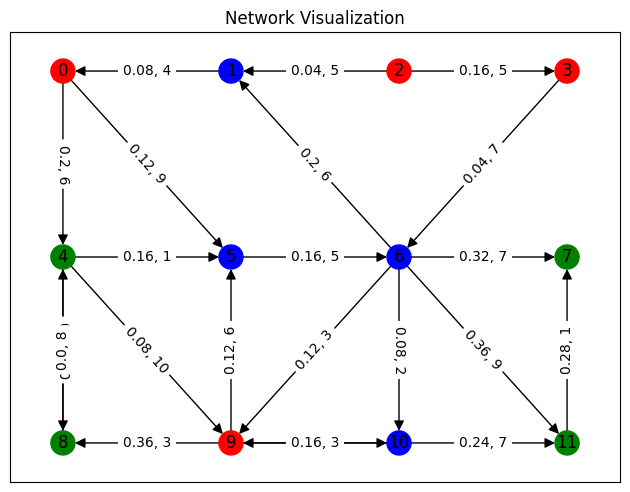

In [ ]:
# get default simulation parameters
network_type = 'single-user' # available choices = 'single-user' 'multi-user'
simulation_params = pars.get_simulation_params(network_type, is_regret_sim = True)

# redefine some variables locally for ease of use
T_horizon_list = simulation_params.T_horizon_list
arrival_rate_scaling = simulation_params.arrival_rate_scaling
noise_variance = simulation_params.noise_variance

## Static Policy

In [3]:
# get static minimum rates (Theorem 1 of the paper)
stat_edge_rates, backlog_cost_C_L = polc.get_static_policy(simulation_params)

# get minimum static costs and convert them to per-time arrays
N_edges         = len(simulation_params.edge_capacities)
N_commodities   = len(simulation_params.destination_list)
stat_cost_at_tt = np.sum(stat_edge_rates.reshape([N_commodities, N_edges])@simulation_params.true_edge_costs)
stat_costs      = T_horizon_list*stat_cost_at_tt

## DPOP Policy

In [4]:
# intialization
dpop_tran_costs = np.zeros(T_horizon_list.shape)
dpop_backlogs = np.zeros(T_horizon_list.shape)

# iterate over given T values
for ii in trange(T_horizon_list.shape[0]):
    # ii = T_horizon_list.shape[0] - jj - 1
    # change policy parameters for this value of T
    simulation_params = pars.set_simulation_params(simulation_params, T_horizon_list[ii])

    # run experiment for this value of T
    queueing_network = expt.run_experiment(simulation_params, custom_seed = 13)
    
    # save cost and backlog values
    dpop_tran_costs[ii], dpop_backlogs[ii] = expt.calculate_total_costs(queueing_network)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/Simulations/Optimistic-DPP-Improved-Regret/utils/network.py:121: RuntimeWarning: divide by zero encountered in matmul
  self.planned_tran_cost_at_tt[self.tt] = np.mean(np.sum(planned_edge_rates, axis=1)@self.true_edge_costs, axis=0)
/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/Simulations/Optimistic-DPP-Improved-Regret/utils/network.py:121: RuntimeWarning: overflow encountered in matmul
  self.planned_tran_cost_at_tt[self.tt] = np.mean(np.sum(planned_edge_rates, axis=1)@self.true_edge_costs, axis=0)
/Users/sathwikchadaga/MIT Dropbox/Sathwik Chadaga/MIT/Research/Learning DPOP/Simulations/Optimistic-DPP-Improved-Regret/utils/network.py:121: RuntimeWarning: invalid value encountered in matmul
  self.planned_tran_cost_at_tt[self.tt] = np.mean(np.sum(planned_edge_rates, axis=1)@self.true_edge_costs, axis=0)
/Users/sathwikchadaga/MIT Dropbox/Sathw

# Save Results

In [ ]:
# save results
save_directory = './results/regret-sweep/' + network_type # set to None if dont want to save
save_folder = None

save_result = {'T_horizon_list': T_horizon_list, 
                'dpop_tran_costs': dpop_tran_costs, 
                'dpop_backlogs': dpop_backlogs, 
                'C_L': backlog_cost_C_L,
                'stat_costs':stat_costs, 
                'edge_cost_means': queueing_network.edge_cost_means[0,:], 
                'true_edge_costs': simulation_params.true_edge_costs}
save_file = 'regret-lambda-' + ('%.3f'%(arrival_rate_scaling)).replace('.','_') + '-var-' + str(noise_variance).replace('.','_') + '.pkl'
if(save_directory is not None): 
    with open(save_directory + '/' + save_file, 'wb') as f: pkl.dump(save_result, f)

## Results Summary

Fit co-effs [1 sqrt(T)log(T)] = [12998.85      6.446]
Arrival rate = 1, noise variance = 0.1
True costs = [0.08 0.2  0.12 0.04 0.16 0.04 0.16 0.08 0.08 0.16 0.2  0.32 0.12 0.08
 0.36 0.   0.12 0.36 0.28 0.16 0.24 0.28]
Mean observed costs = [0.078 0.201 0.121 0.04  0.156 0.039 0.159 0.08  0.08  0.16  0.199 0.318
 0.12  0.079 0.367 0.002 0.119 0.372 0.28  0.162 0.234 0.281]
backlog_cost_C_L = 9.68


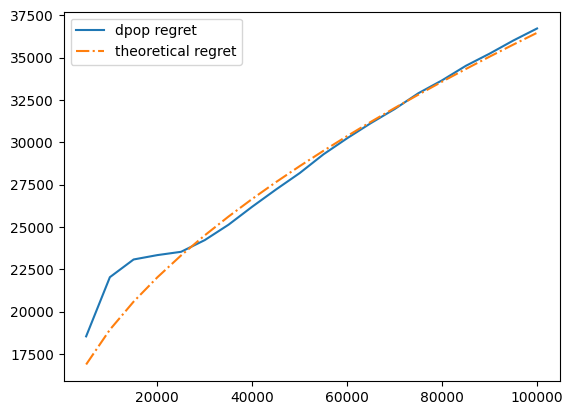

In [ ]:
# get theoretical fit
dpop_regret = dpop_tran_costs + dpop_backlogs*backlog_cost_C_L - stat_costs
theoretical_dpop_regret = pltutils.fit_regret_curve(T_horizon_list, dpop_regret)

# print summary
print('Arrival rate = ' + str(arrival_rate_scaling) + ', noise variance = ' + str(noise_variance))
print('True costs = ' + str(simulation_params.true_edge_costs))
print('Mean observed costs = ' + np.array2string(queueing_network.edge_cost_means[0,:], precision=3, suppress_small=True))
print('backlog_cost_C_L = ' + str(backlog_cost_C_L))

# plot regret
plt.plot(T_horizon_list, dpop_tran_costs + dpop_backlogs*backlog_cost_C_L - stat_costs, label = 'dpop regret')
plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
plt.legend()
plt.show()